In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

%matplotlib inline
pd.set_option('max_colwidth',1000)

In [2]:
# Load the loan data
df = pd.read_pickle('data_cleaned.pkl')
df.reset_index(drop=True, inplace=True)

from sklearn.utils import shuffle
df = shuffle(df)

# Load the dictionary from Lending Club data
loan_dict = pd.read_excel(open('LCDataDictionary.xlsx','rb'), sheet_name='LoanStats')

In [3]:
# Features and their meanings.
for f in df.columns:
    print(f)
    print(loan_dict.loc[loan_dict['LoanStatNew'] == f]['Description'])
    print('------')

loan_amnt
41    The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
Name: Description, dtype: object
------
funded_amnt
23    The total amount committed to that loan at that point in time.
Name: Description, dtype: object
------
funded_amnt_inv
24    The total amount committed by investors for that loan at that point in time.
Name: Description, dtype: object
------
term
94    The number of payments on the loan. Values are in months and can be either 36 or 60.
Name: Description, dtype: object
------
int_rate
34    Interest Rate on the loan
Name: Description, dtype: object
------
installment
33    The monthly payment owed by the borrower if the loan originates.
Name: Description, dtype: object
------
grade
25    LC assigned loan grade
Name: Description, dtype: object
------
sub_grade
92    LC assigned loan subgrade
Name: Description, dtype: object
------
emp_length
19 

In [4]:
# Split the data in features and target label
loan_status_raw = df['loan_status']
features = df.drop('loan_status', axis=1)

# Encode the loan_status_raw to numerical values
# Fully Paid = 1
# Charged Off = 0
loan_status = loan_status_raw.apply(lambda x: int(x == 'Fully Paid'))

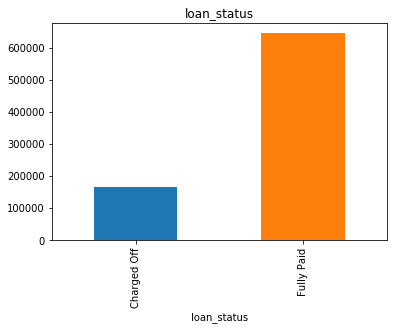

In [5]:
df.groupby('loan_status').size().plot(kind='bar', title='loan_status')

In [6]:
# Categorical features 
cat_features = features.select_dtypes(include=['object']).columns
print(cat_features)

for y in cat_features:
    features = features.join(pd.get_dummies(features[y], prefix=y))
    features.drop(y, axis=1, inplace=True)

Index(['grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'purpose', 'addr_state', 'initial_list_status'],
      dtype='object')


In [7]:
# In addition, remove int_rate also as that is also a predicted component
features.drop('int_rate', axis=1, inplace=True)

In [8]:
# Total number of records
n_records = len(loan_status.index)

print(type(loan_status))
# Number of records where loan status is 'Fully Paid'
n_fully_paid = loan_status.sum()

# Number of records where loan status is 'Charged Off
n_charged_off = n_records - n_fully_paid

# Percentage of loan default
loan_default = 100 * float(n_charged_off) / n_records

print("Total number of records: {}".format(n_records))
print("Total number of good loans: {}".format(n_fully_paid))
print("Total number of bad loans: {}".format(n_charged_off))
print("Percentage of bad loans: {}".format(loan_default))

<class 'pandas.core.series.Series'>
Total number of records: 810576
Total number of good loans: 644292
Total number of bad loans: 166284
Percentage of bad loans: 20.514300941552673


In [9]:
from sklearn.cross_validation import train_test_split

# Split the features and loan_status data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, loan_status, test_size = 0.2, random_state = 0)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

/home/anilraj/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Training set has 648460 samples.
Testing set has 162116 samples.


In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
       
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train, learner.predict(X_train))
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, learner.predict(X_test))
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train, learner.predict(X_train), beta=0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, learner.predict(X_test), beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [11]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()

result = train_predict(clf, len(y_train), X_train, y_train, X_test, y_test)
result

GaussianNB trained on 648460 samples.


{'train_time': 2.718536853790283,
 'pred_time': 2.864079475402832,
 'acc_train': 0.45385066156740583,
 'acc_test': 0.4535887882750623,
 'f_train': 0.683875951689743,
 'f_test': 0.6827961659861582}